In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import TimeDistributed, Bidirectional
from matplotlib import pyplot as plt
import tensorflow
from tensorflow.keras.models import Model, load_model

LOAD FILE DATA

In [2]:
path_data = 'data/ner.txt'
with open(path_data, 'r',encoding='utf8') as f:
    data = f.readlines() 
    

DEFINE 


In [3]:
begin_labels = ["B", "I"]
ner_labels = ["SYS.FULL_NAME"]
max_word = 15
max_character = 6
max_charac_embed = max_word*max_character

BUILD VOCAB

In [4]:
corpus = []
for line in tqdm(data):
    splitted_sentence = line.split('\t')
    
    sentence = splitted_sentence[0]
    name_lower = splitted_sentence[1][:splitted_sentence[1].find('|')]
    
    # sentence_capitalize = sentence.replace(name_lower, name_lower.title())
    corpus.extend(list(sentence))
    corpus.extend(list(name_lower.title()))
    
corpus =  pd.Series(corpus)
vocab = corpus.unique ()

100%|████████████████████████████████████████████| 3998/3998 [00:00<00:00, 373412.33it/s]


BUILD DICTIONARY

In [5]:
charac2idx = {w : i + 2 for i, w in enumerate(vocab)}
charac2idx["UNK"] = 1
charac2idx["PAD"] = 0
idx2charac = {i: w for w, i in charac2idx.items()}

cap2idx = {'False':0, 'True':1}
cap2idx["PAD"] = 0
idx2cap = {0:'False', 1:'True'}

PADDING FUNCTION

In [6]:
def padding (characters, max_padding, value_padding):
    if len(characters)>max_padding:
        return characters[0:max_padding]
    else:
        characters.extend([value_padding]*(max_padding-len(characters)))
        return characters

PROCESS DATA

In [7]:
X = []
y = []
for i,line in enumerate(data):
         
    splitted_sentence = line.split('\t')
    
    sentence = splitted_sentence[0]
    name_lower = splitted_sentence[1][:splitted_sentence[1].find('|')]
    
    capitalized_sentence = sentence.replace(name_lower, name_lower.title())
    capitalized_label = [cap2idx[str(label.isupper())] for label in list(capitalized_sentence)]
    y.append(padding(characters=capitalized_label, max_padding=max_charac_embed, value_padding=cap2idx["PAD"]))
    
    lowered_sentence = [charac2idx[charater] for charater in list(sentence)]
    X.append(padding(characters=lowered_sentence, max_padding=max_charac_embed, value_padding=charac2idx["PAD"]))
    

In [9]:
print(len(y))
print(len(X))

3998
3998


In [10]:
y = [to_categorical(i, num_classes = 2) for i in y]
X = np.array(X)
y = np.array(y)

In [11]:
print(y.shape)
print(X.shape)

(3998, 90, 2)
(3998, 90)


In [12]:
X = X.reshape(3998,90,1)

In [13]:
print(y.shape)
print(X.shape)

(3998, 90, 2)
(3998, 90, 1)


BUILD MODEL

In [14]:
model = Sequential()
model.add(Embedding(input_dim=len(vocab)+2, output_dim= 50, input_length=max_charac_embed))
model.add(Bidirectional(LSTM(units=20, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(2, activation="softmax")))
# compile the model
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
model.summary()
# fit the model


2021-11-01 16:23:49.709095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 90, 50)            8100      
_________________________________________________________________
bidirectional (Bidirectional (None, 90, 40)            11360     
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 2)             82        
Total params: 19,542
Trainable params: 19,542
Non-trainable params: 0
_________________________________________________________________


2021-11-01 16:23:49.712163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 16:23:49.712278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 16:23:49.712952: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-01 16:23:49.713440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [ ]:
a = model.predict(X[0:3900])
print(a.shape)

In [108]:
print(X[3979])
print(len(X[3979])

[  7  10  11   4  70   4  85   6  11   4  23  90   9   4   7  24  11   4
 133  47 133   4   9  23  19  20   8 160   9   4   5  61   9   4  35  39
 153  49   4  43   2  39  40   9  23   4 139  99  49   4  89  19  80   9
   4 132   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
90


In [15]:
history = model.fit(X, y, epochs=50, verbose=2, workers=8, batch_size=8, validation_split=4/10)

2021-11-01 16:24:03.361507: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-01 16:24:05.914215: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


300/300 - 78s - loss: 0.3135 - accuracy: 0.9616 - val_loss: 0.0553 - val_accuracy: 0.9917
Epoch 2/50
300/300 - 75s - loss: 0.0976 - accuracy: 0.9781 - val_loss: 0.0542 - val_accuracy: 0.9917
Epoch 3/50
300/300 - 75s - loss: 0.0921 - accuracy: 0.9781 - val_loss: 0.0522 - val_accuracy: 0.9917
Epoch 4/50
300/300 - 76s - loss: 0.0890 - accuracy: 0.9781 - val_loss: 0.0500 - val_accuracy: 0.9917
Epoch 5/50
300/300 - 75s - loss: 0.0862 - accuracy: 0.9781 - val_loss: 0.0508 - val_accuracy: 0.9917
Epoch 6/50
300/300 - 76s - loss: 0.0822 - accuracy: 0.9781 - val_loss: 0.0484 - val_accuracy: 0.9917
Epoch 7/50
300/300 - 76s - loss: 0.0758 - accuracy: 0.9781 - val_loss: 0.0446 - val_accuracy: 0.9917
Epoch 8/50
300/300 - 75s - loss: 0.0699 - accuracy: 0.9781 - val_loss: 0.0432 - val_accuracy: 0.9917
Epoch 9/50
300/300 - 76s - loss: 0.0651 - accuracy: 0.9781 - val_loss: 0.0432 - val_accuracy: 0.9917
Epoch 10/50
300/300 - 76s - loss: 0.0609 - accuracy: 0.9781 - val_loss: 0.0421 - val_accuracy: 0.9917


In [15]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


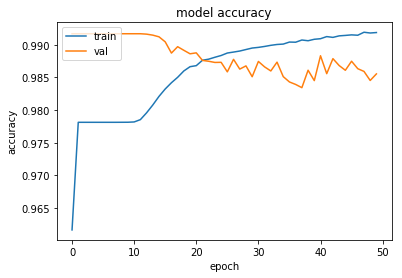

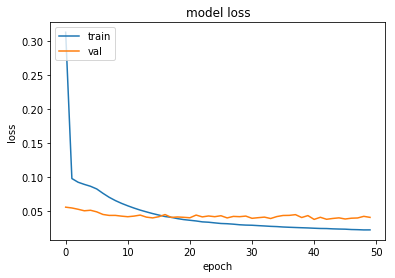

In [16]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
model.save('model/truecasing_model_new.h5')